In [ ]:
#Importação das libs necessárias
import pandas as pd
import string
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW


In [ ]:
#Carregamento do modelo BERTimbau pré-treinado e do tokenizer
model_name = 'neuralmind/bert-base-portuguese-cased'
bert_model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
#Carregamento dos dados
df_nomes = pd.read_csv('nomes_pessoais.csv')
df_nomes['y'] = 1

df_palavras = pd.read_csv('palavras_comuns.csv').sample(n=102561, random_state=42)
df_palavras['y'] = 0

df = pd.concat([df_nomes, df_palavras])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205122 entries, 0 to 94397
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   X       205122 non-null  object
 1   y       205122 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ MB


In [ ]:
#Divisão do conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.3, random_state=42, stratify=df['y'])


In [ ]:
#Tokenização dos dados para BERT
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt')
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors='pt')


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
#Treinamento do modelo BERT
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
loss_function = torch.nn.CrossEntropyLoss()

train_dataset = TensorDataset(X_train_tokens['input_ids'], X_train_tokens['attention_mask'], torch.tensor(y_train.values))
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=64)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Movendo o modelo e o otimizador para o dispositivo
bert_model.to(device)
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
print(device)

cuda


In [ ]:
# Loop de treinamento
for epoch in range(10):  #10 épocas de treinamento
    print(f'Época {epoch + 1}/{10}:')
    bert_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        total_correct += torch.sum(preds == labels).item()
        total_samples += len(labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:  # A cada 10 batches imprime em tela a acurácia média e loss
            avg_train_loss = total_loss / (batch_idx + 1)
            avg_train_accuracy = total_correct / total_samples
            print(f'    Batch {batch_idx + 1}/{len(train_dataloader)} - Loss: {loss.item():.4f}, Acurácia: {avg_train_accuracy:.4f}')

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_correct / total_samples
    print(f'Treinamento - Loss: {avg_train_loss:.4f}, Acurácia: {avg_train_accuracy:.4f}')

    # Impressão da métrica de treinamento após cada época
    print("Métricas após treinamento:")
    print(f"Época {epoch + 1} - Loss médio: {avg_train_loss:.4f}, Acurácia média: {avg_train_accuracy:.4f}")


Época 1/10:
    Batch 10/2244 - Loss: 0.4990, Acurácia: 0.7766
    Batch 20/2244 - Loss: 0.2175, Acurácia: 0.8453
    Batch 30/2244 - Loss: 0.2417, Acurácia: 0.8714
    Batch 40/2244 - Loss: 0.2205, Acurácia: 0.8867
    Batch 50/2244 - Loss: 0.1654, Acurácia: 0.8972
    Batch 60/2244 - Loss: 0.1525, Acurácia: 0.9031
    Batch 70/2244 - Loss: 0.0960, Acurácia: 0.9089
    Batch 80/2244 - Loss: 0.1889, Acurácia: 0.9129
    Batch 90/2244 - Loss: 0.0629, Acurácia: 0.9177
    Batch 100/2244 - Loss: 0.2665, Acurácia: 0.9209
    Batch 110/2244 - Loss: 0.0733, Acurácia: 0.9230
    Batch 120/2244 - Loss: 0.0711, Acurácia: 0.9245
    Batch 130/2244 - Loss: 0.1893, Acurácia: 0.9237
    Batch 140/2244 - Loss: 0.0940, Acurácia: 0.9232
    Batch 150/2244 - Loss: 0.1074, Acurácia: 0.9246
    Batch 160/2244 - Loss: 0.3015, Acurácia: 0.9251
    Batch 170/2244 - Loss: 0.1984, Acurácia: 0.9260
    Batch 180/2244 - Loss: 0.0995, Acurácia: 0.9270
    Batch 190/2244 - Loss: 0.0568, Acurácia: 0.9284
    Batch

In [ ]:
# Salvando o modelo treinado
torch.save(bert_model.state_dict(), 'modelo_treinado.pth')

In [ ]:
#Avaliação do modelo BERT
print("Iniciando avaliação do modelo BERT...")
bert_model.eval()
test_dataset = TensorDataset(X_test_tokens['input_ids'], X_test_tokens['attention_mask'])
test_dataloader = DataLoader(test_dataset, batch_size=64)

y_pred_bert = []
total_batches = len(test_dataloader)
batch_count = 0

for batch in test_dataloader:
    batch_count += 1
    print(f'Avaliando batch {batch_count}/{total_batches}...')
    input_ids, attention_mask = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    y_pred_bert.extend(preds.tolist())

print("Avaliação concluída.")

Iniciando avaliação do modelo BERT...
Avaliando batch 1/962...
Avaliando batch 2/962...
Avaliando batch 3/962...
Avaliando batch 4/962...
Avaliando batch 5/962...
Avaliando batch 6/962...
Avaliando batch 7/962...
Avaliando batch 8/962...
Avaliando batch 9/962...
Avaliando batch 10/962...
Avaliando batch 11/962...
Avaliando batch 12/962...
Avaliando batch 13/962...
Avaliando batch 14/962...
Avaliando batch 15/962...
Avaliando batch 16/962...
Avaliando batch 17/962...
Avaliando batch 18/962...
Avaliando batch 19/962...
Avaliando batch 20/962...
Avaliando batch 21/962...
Avaliando batch 22/962...
Avaliando batch 23/962...
Avaliando batch 24/962...
Avaliando batch 25/962...
Avaliando batch 26/962...
Avaliando batch 27/962...
Avaliando batch 28/962...
Avaliando batch 29/962...
Avaliando batch 30/962...
Avaliando batch 31/962...
Avaliando batch 32/962...
Avaliando batch 33/962...
Avaliando batch 34/962...
Avaliando batch 35/962...
Avaliando batch 36/962...
Avaliando batch 37/962...
Avaliando

Acurácia BERT:  0.9750556575718673
Precisão BERT:  0.971728255607552
Recall BERT:  0.9785816432657306
F1-score BERT:  0.9751429080368565


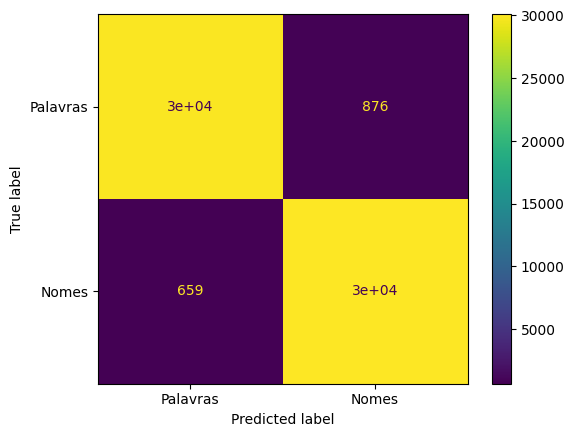

In [ ]:
#Métricas de avaliação e visualização dos resultados
accuracy_bert = accuracy_score(y_test, y_pred_bert)
precision_bert = precision_score(y_test, y_pred_bert)
recall_bert = recall_score(y_test, y_pred_bert)
f1_bert = f1_score(y_test, y_pred_bert)
conf_matrix_bert = confusion_matrix(y_test, y_pred_bert)
display_bert = ConfusionMatrixDisplay(conf_matrix_bert, display_labels=['Palavras', 'Nomes'])

pd.set_option('display.float_format', lambda x: '%.0f' % x)

print("Acurácia BERT: ", accuracy_bert)
print("Precisão BERT: ", precision_bert)
print("Recall BERT: ", recall_bert)
print("F1-score BERT: ", f1_bert)
